In [47]:
import matplotlib.pyplot as plt
import torchvision.models as models

from flashtorch.utils import apply_transforms, load_image
from flashtorch.saliency import Backprop

import numpy as np

import mnist import MNIST
import scipy.misc

SyntaxError: invalid syntax (<ipython-input-47-a7542c5c35bd>, line 9)

In [48]:
# Run if on a Mac
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [49]:
image = load_image('adorable_puppy.jpg')

plt.imshow(image)
plt.title('Original image')
plt.axis('off');

noisy_img = image + np.random.normal(0, 5, (image.size[1],image.size[0], 3))

# Prepare inputs to be used later

img = apply_transforms(noisy_img.astype('uint8'))

NameError: name 'MNIST' is not defined

In [38]:
def visualize_helper(model_module, tensor=img, k=84):
    model = model_module(pretrained=True)
    backprop = Backprop(model)
    backprop.visualize(tensor, k, guided=True)

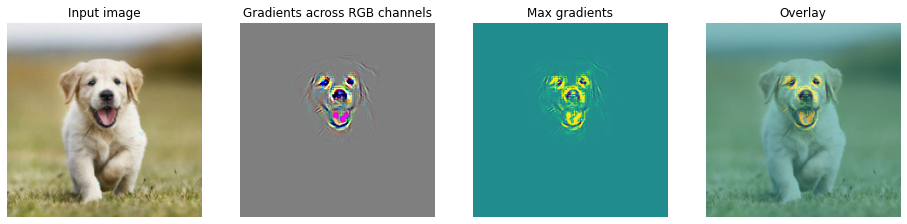

In [39]:
visualize_helper(models.alexnet)

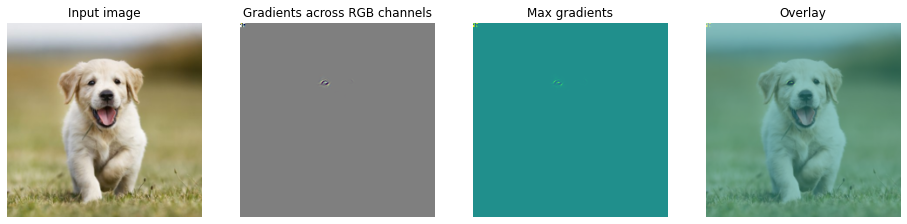

In [7]:
visualize_helper(models.resnet50)